### **Notebook 2 — Data Merging, EDA & Post - Merge Cleaning**

In Notebook-1 we performed raw data cleaning separately for:
- Train dataset
- Test dataset
- Store dataset

In this notebook we will:

1. Merge store metadata with transactional datasets
2. Perform post-merge business cleaning
3. Remove logically incorrect records
4. Perform Exploratory Data Analysis (EDA)
5. Detect and treat outliers
6. Understand important features affecting sales
7. Save final datasets for machine learning

***`Important`***:
Cleaning after merge is necessary because new inconsistencies appear
only after combining datasets (e.g., store closed but sales recorded).

Output:
- final_train.csv
- final_test.csv

#### **IMPORTING MODULES/LIBRARIES**
This section will import all the libraries or modules required to add details in the cleaning and EDA process.

In [1]:
import io
import os
import logging
import pandas as pd

#### **LOGGER SETUP**

In [34]:
if not os.path.exists("logs"):
    os.makedirs("logs")

logging.basicConfig(
    filename="logs/merge_eda.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger(__name__)

def print_and_log(message, level='info'):
    print(message)
    if level == 'info':
        logger.info(message)
    elif level == 'warning':
        logger.warning(message)
    elif level == 'error':
        logger.error(message)
    else:
        logger.debug(message)       
print_and_log("===== MERGE & EDA PIPELINE STARTED =====")

===== MERGE & EDA PIPELINE STARTED =====


#### **STEP 1 — LOAD CLEAN DATASETS**

We will load:
- train_clean.csv
- test_clean.csv
- store_clean.csv

In [35]:
logger.info("Loading cleaned datasets...")

train = pd.read_csv("train_clean.csv", parse_dates=["date"])
test = pd.read_csv("test_clean.csv", parse_dates=["date"])
store = pd.read_csv("store_clean.csv")

print_and_log(f"Train shape: {train.shape}")
print_and_log(f"Test shape: {test.shape}")
print_and_log(f"Store shape: {store.shape}")
print_and_log("Merging datasets...")

C:\Users\Aishwarya Kr Singh\AppData\Local\Temp\ipykernel_21648\3777027309.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train_clean.csv", parse_dates=["date"])


Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)
Merging datasets...


_____________________________________________

#### **STEP 2 — MERGE TRAIN WITH STORE**

Store dataset contains metadata such as:
- Store type
- Competition distance
- Promotion details

These directly affect sales and must be attached to transactional records.

In [36]:
logger.info("Merging train with store")
train_merged = train.merge(store, on="store", how="left")

print_and_log(f"train_merged.shape: {train_merged.shape}")
train_merged.head()

train_merged.shape: (1017209, 18)


,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,NaN


_____________________________________________
### **STEP 3 — MERGE TEST WITH STORE**
Same merging logic must be applied to test data.
This prevents training-serving skew.

In [37]:
logger.info("Merging test with store...")

test_merged = test.merge(store, on="store", how="left")

print_and_log(f"test_merged.shape: {test_merged.shape}")
test_merged.head()

test_merged.shape: (41088, 17)


,id,store,dayofweek,date,open,promo,stateholiday,schoolholiday,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,2,3,4,2015-09-17,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,NaN
3,4,8,4,2015-09-17,1,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,NaN
4,5,9,4,2015-09-17,1,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,NaN


_____________________________________________

### **STEP 4 — POST-MERGE CLEANING (BUSINESS RULE CLEANING)**

Here we will clean the merged data and then we will proceed with the EDA.
After merging, logical errors appear that were not visible earlier.

We now remove unrealistic business records:
- Stores closed but sales recorded
- Zero sales rows
- Newly created null values

#### 3.1 Removing closed stores with Sales - **`train_merge`**

In [38]:
logger.info("Removing rows where store closed but sales recorded...")

before = len(train_merged)
train_merged = train_merged[~((train_merged["open"] == 0) & (train_merged["sales"] > 0))]
after = len(train_merged)
print_and_log(f"Removed {before - after} invalid closed-store records")

Removed 0 invalid closed-store records


#### 3.2 Remove Zero Sales Rows - **`train_merge`**

In [39]:
logger.info("Removing zero sales rows...")

before = len(train_merged)
train_merged = train_merged[train_merged["sales"] > 0]
after = len(train_merged)
print_and_log(f"Removed {before - after} zero-sales records")
print_and_log(f"Shape of train_merged: {train_merged.shape}")
train_merged.describe()

Removed 172871 zero-sales records
Shape of train_merged: (844338, 18)


,store,dayofweek,date,sales,customers,open,promo,schoolholiday,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear
count,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.0,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,2014-04-11 01:08:38.729702912,6955.959134,762.777166,1.0,0.446356,0.193578,5450.044852,4.926482,1369.692738,0.498670,11.596159,1003.201259
min,1.000000,1.000000,2013-01-01 00:00:00,46.000000,8.000000,1.0,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,2013-08-16 00:00:00,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.000000,3.000000,2014-03-31 00:00:00,6369.000000,676.000000,1.0,0.000000,0.000000,2325.000000,4.000000,2006.000000,0.000000,0.000000,0.000000
75%,837.000000,5.000000,2014-12-11 00:00:00,8360.000000,893.000000,1.0,1.000000,0.000000,6880.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.000000,7.000000,2015-07-31 00:00:00,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000
std,321.730861,1.723712,NaN,3103.815515,401.194153,0.0,0.497114,0.395102,7801.082007,4.283634,935.556484,0.499999,15.308101,1005.874685


#### 3.3 Handle Nulls Created After Merge - **`train_merge`**

In [40]:
logger.info("Handling null values, that are created after merge...")
print_and_log(f"train_merged null values before they are handled: {train_merged.isnull().sum().to_dict()}")
for col in train_merged.select_dtypes(include="number"):
    train_merged[col] = train_merged[col].fillna(train_merged[col].median())

for col in train_merged.select_dtypes(include="category"):
    train_merged[col] = train_merged[col].fillna("None")

print_and_log(f"Null values handled in train_merged! Count of nulls after handling: {train_merged.isnull().sum().to_dict()}")
train_merged.head()

train_merged null values before they are handled: {'store': 0, 'dayofweek': 0, 'date': 0, 'sales': 0, 'customers': 0, 'open': 0, 'promo': 0, 'stateholiday': 0, 'schoolholiday': 0, 'storetype': 0, 'assortment': 0, 'competitiondistance': 0, 'competitionopensincemonth': 0, 'competitionopensinceyear': 0, 'promo2': 0, 'promo2sinceweek': 0, 'promo2sinceyear': 0, 'promointerval': 423292}
Null values handled in train_merged! Count of nulls after handling: {'store': 0, 'dayofweek': 0, 'date': 0, 'sales': 0, 'customers': 0, 'open': 0, 'promo': 0, 'stateholiday': 0, 'schoolholiday': 0, 'storetype': 0, 'assortment': 0, 'competitiondistance': 0, 'competitionopensincemonth': 0, 'competitionopensinceyear': 0, 'promo2': 0, 'promo2sinceweek': 0, 'promo2sinceyear': 0, 'promointerval': 423292}


,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,NaN


#### 3.4 Handle Missing Values - **`test_merge`**

After merging, test data can also have:

- null values
- store closed rows
- metadata NaNs
- inconsistent promo fields

We cannot remove rows based on sales because test has no sales column — but all other operations must match.

In [41]:
logger.info("Handling missing values in test...")

for col in test_merged.select_dtypes(include="number"):
    test_merged[col] = test_merged[col].fillna(test_merged[col].median())

for col in test_merged.select_dtypes(exclude="number"):
    test_merged[col] = test_merged[col].fillna("None")
print_and_log(f"Null values handled in test_merged! Count of nulls after handling: {test_merged.isnull().sum().to_dict()}")
test_merged.head()

Null values handled in test_merged! Count of nulls after handling: {'id': 0, 'store': 0, 'dayofweek': 0, 'date': 0, 'open': 0, 'promo': 0, 'stateholiday': 0, 'schoolholiday': 0, 'storetype': 0, 'assortment': 0, 'competitiondistance': 0, 'competitionopensincemonth': 0, 'competitionopensinceyear': 0, 'promo2': 0, 'promo2sinceweek': 0, 'promo2sinceyear': 0, 'promointerval': 0}


,id,store,dayofweek,date,open,promo,stateholiday,schoolholiday,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,3,4,2015-09-17,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,None
3,4,8,4,2015-09-17,1,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,None
4,5,9,4,2015-09-17,1,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,None


#### 3.5 Ensuring same datatypes (TRAIN & TEST)
This will prevent model prediction errors.

***Why this step is critical***
Without datatype alignment we may get errors like:
`ValueError: could not convert string to float`

or may be model will run but will predict unrelated things which might not be correct.

In [42]:
logger.info("Aligning datatypes between train and test...")

for col in train_merged.columns:
    if col in test_merged.columns:
        test_merged[col] = test_merged[col].astype(train_merged[col].dtype)
logger.info("Datatypes aligned between train and test")

#### **What we DID NOT apply to test**

We did not apply:
- sales filtering
- outlier removal based on sales

because test has no target.

_____________________________________________

### **STEP 5 — BASIC FEATURE UNDERSTANDING**

We examine important business features:
- Promotion
- Competition
- Holidays
- Customers

In [43]:
logger.info(f"Feature understanding: {train_merged.describe()}")
train_merged.describe()

,store,dayofweek,date,sales,customers,open,promo,schoolholiday,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear
count,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.0,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,2014-04-11 01:08:38.729702912,6955.959134,762.777166,1.0,0.446356,0.193578,5450.044852,4.926482,1369.692738,0.498670,11.596159,1003.201259
min,1.000000,1.000000,2013-01-01 00:00:00,46.000000,8.000000,1.0,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,2013-08-16 00:00:00,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.000000,3.000000,2014-03-31 00:00:00,6369.000000,676.000000,1.0,0.000000,0.000000,2325.000000,4.000000,2006.000000,0.000000,0.000000,0.000000
75%,837.000000,5.000000,2014-12-11 00:00:00,8360.000000,893.000000,1.0,1.000000,0.000000,6880.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.000000,7.000000,2015-07-31 00:00:00,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000
std,321.730861,1.723712,NaN,3103.815515,401.194153,0.0,0.497114,0.395102,7801.082007,4.283634,935.556484,0.499999,15.308101,1005.874685


_____________________________________________

### **STEP 6 — EXPLORATORY DATA ANALYSIS (EDA)**

Goal:
Understand data behaviour before modeling.

EDA will include:
- Datatype audit
- Date feature extraction
- Identifying categorical & numerical variables
- Univariate analysis
- Bivariate analysis
- Multivariate analysis
- Time-based patterns

EDA will be performed ONLY on `train_merged` because it contains the target variable (Sales).

#### 6.1 Data Type Audit
We will first inspect structure, datatypes, and missing values.

In [44]:
logger.info("Performing dataset structure audit")
buf = io.StringIO()
train_merged.info()
train_merged.info(buf=buf)
logger.info("Dataset info:\n" + buf.getvalue())

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   store                      844338 non-null  int64         
 1   dayofweek                  844338 non-null  int64         
 2   date                       844338 non-null  datetime64[ns]
 3   sales                      844338 non-null  int64         
 4   customers                  844338 non-null  int64         
 5   open                       844338 non-null  int64         
 6   promo                      844338 non-null  int64         
 7   stateholiday               844338 non-null  object        
 8   schoolholiday              844338 non-null  int64         
 9   storetype                  844338 non-null  object        
 10  assortment                 844338 non-null  object        
 11  competitiondistance        844338 non-null  float64     

In [45]:
logger.info(f"Displaying first few rows of the merged train dataset:\n {train_merged.head().to_string()}")
train_merged.head()

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,storetype,assortment,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear,promointerval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,NaN


In [46]:
logger.info(f"Displaying statistical summary of the merged train dataset:\n {train_merged.describe().to_string()}")  
train_merged.describe()

,store,dayofweek,date,sales,customers,open,promo,schoolholiday,competitiondistance,competitionopensincemonth,competitionopensinceyear,promo2,promo2sinceweek,promo2sinceyear
count,844338.000000,844338.000000,844338,844338.000000,844338.000000,844338.0,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000,844338.000000
mean,558.421374,3.520350,2014-04-11 01:08:38.729702912,6955.959134,762.777166,1.0,0.446356,0.193578,5450.044852,4.926482,1369.692738,0.498670,11.596159,1003.201259
min,1.000000,1.000000,2013-01-01 00:00:00,46.000000,8.000000,1.0,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,2013-08-16 00:00:00,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,558.000000,3.000000,2014-03-31 00:00:00,6369.000000,676.000000,1.0,0.000000,0.000000,2325.000000,4.000000,2006.000000,0.000000,0.000000,0.000000
75%,837.000000,5.000000,2014-12-11 00:00:00,8360.000000,893.000000,1.0,1.000000,0.000000,6880.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000
max,1115.000000,7.000000,2015-07-31 00:00:00,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000
std,321.730861,1.723712,NaN,3103.815515,401.194153,0.0,0.497114,0.395102,7801.082007,4.283634,935.556484,0.499999,15.308101,1005.874685


#### 6.2 Date Conversion & Feature Extraction
Sales depend heavily on calendar patterns.
We extract useful time components from Date column.

In [47]:
logger.info("Extracting date features")

train_merged["year"] = train_merged["date"].dt.year
train_merged["month"] = train_merged["date"].dt.month
train_merged["day"] = train_merged["date"].dt.day
train_merged["weekday"] = train_merged["date"].dt.weekday
train_merged["weekofyear"] = train_merged["date"].dt.isocalendar().week.astype(int)
train_merged["is_weekend"] = train_merged["weekday"].apply(lambda x: 1 if x>=5 else 0)
logger.info("Date features extracted successfully!")

#### 6.3 Handling the duplicates

In [48]:
train_merged = train_merged.drop_duplicates()
train_merged["date"] = pd.to_datetime(train_merged["date"], errors="coerce")

# Ensure numeric columns
num_cols = ["Sales", "Customers", "CompetitionDistance"]
for col in num_cols:
    if col in train_merged.columns:
        train_merged[col] = pd.to_numeric(train_merged[col], errors="coerce")

train_merged.info()
logger.info("Duplicates removed and datatypes standardized successfully!")

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   store                      844338 non-null  int64         
 1   dayofweek                  844338 non-null  int64         
 2   date                       844338 non-null  datetime64[ns]
 3   sales                      844338 non-null  int64         
 4   customers                  844338 non-null  int64         
 5   open                       844338 non-null  int64         
 6   promo                      844338 non-null  int64         
 7   stateholiday               844338 non-null  object        
 8   schoolholiday              844338 non-null  int64         
 9   storetype                  844338 non-null  object        
 10  assortment                 844338 non-null  object        
 11  competitiondistance        844338 non-null  float64     

#### 6.4 Identify Numerical & Categorical Columns
We separate numerical and categorical features.

In [49]:
numerical_cols = train_merged.select_dtypes(include=["int64","float64"]).columns
categorical_cols = train_merged.select_dtypes(include=["object","category"]).columns

print_and_log(f"Numerical columns identified: {numerical_cols.tolist()}")
print_and_log(f"Categorical columns identified: {categorical_cols.tolist()}")

Numerical columns identified: ['store', 'dayofweek', 'sales', 'customers', 'open', 'promo', 'schoolholiday', 'competitiondistance', 'competitionopensincemonth', 'competitionopensinceyear', 'promo2', 'promo2sinceweek', 'promo2sinceyear', 'weekofyear', 'is_weekend']
Categorical columns identified: ['stateholiday', 'storetype', 'assortment', 'promointerval']


#### 6.5 Detect Potential Outliers (Numeric Columns)
Using IQR(Interquartile Range) method:
For each numeric feature:

- Calculate Q1 and Q3
- Compute IQR
- Determine lower & upper bounds:
  [Q1 − 1.5 × IQR , Q3 + 1.5 × IQR]
- Count how many values fall outside the bounds
- Store results for reporting

In [50]:
# -------------------
# OUTLIER SUMMARY 
# -------------------

outlier_summary = []

for col in numerical_cols:
    Q1 = train_merged[col].quantile(0.25)
    Q3 = train_merged[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (train_merged[col] < lower_bound) | (train_merged[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    total_count = train_merged[col].notna().sum()
    outlier_pct = round((outlier_count / total_count) * 100, 2) if total_count > 0 else 0

    outlier_summary.append({
        "Feature": col,
        "Q1": round(Q1, 3),
        "Q3": round(Q3, 3),
        "IQR": round(IQR, 3),
        "Lower Bound": round(lower_bound, 3),
        "Upper Bound": round(upper_bound, 3),
        "Outlier Count": outlier_count,
        "Outlier %": outlier_pct
    })

# Create DataFrame AFTER loop
outliers_df = pd.DataFrame(outlier_summary)
if outliers_df["Outlier Count"].sum() == 0:
    outliers_df = pd.DataFrame({
        "Message": ["No outliers detected in numeric features using IQR method"]
    })
    logger.info("No outliers detected in the dataset")

print_and_log(f"Outlier summary data frame created successfully!\n {outliers_df.to_string(index=False)}")

Outlier summary data frame created successfully!
                   Feature     Q1     Q3    IQR  Lower Bound  Upper Bound  Outlier Count  Outlier %
                    store  280.0  837.0  557.0       -555.5       1672.5              0       0.00
                dayofweek    2.0    5.0    3.0         -2.5          9.5              0       0.00
                    sales 4859.0 8360.0 3501.0       -392.5      13611.5          30769       3.64
                customers  519.0  893.0  374.0        -42.0       1454.0          40853       4.84
                     open    1.0    1.0    0.0          1.0          1.0              0       0.00
                    promo    0.0    1.0    1.0         -1.5          2.5              0       0.00
            schoolholiday    0.0    0.0    0.0          0.0          0.0         163445      19.36
      competitiondistance  710.0 6880.0 6170.0      -8545.0      16135.0          83040       9.83
competitionopensincemonth    0.0    9.0    9.0        -13.5

#### **6.5 UNIVARIATE ANALAYSIS**
Here, we will study one variable at a time for better reporting

##### 6.5.1 Target value distribution(Sales)
Understanding how sales values are distributed.

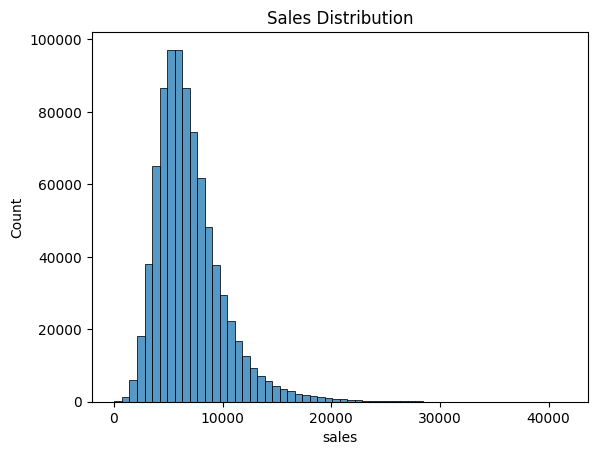

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
logger.info("Plotting sales distribution...")
sns.histplot(train_merged["sales"], bins=60)
plt.title("Sales Distribution")
plt.show()
logger.info("Sales distribution plotted successfully!")

#### 6.5.2 Customers Distribution

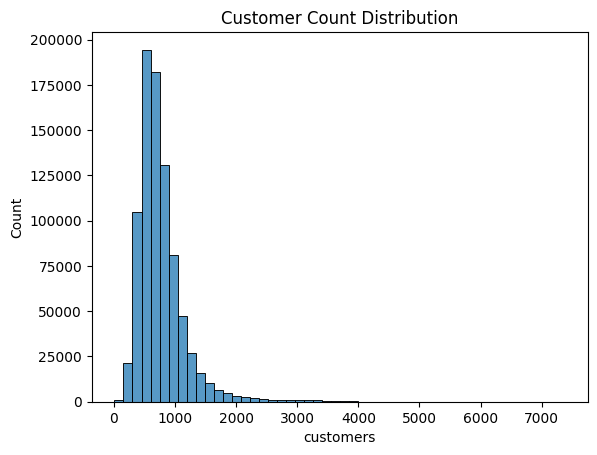

In [52]:
sns.histplot(train_merged["customers"], bins=50)
plt.title("Customer Count Distribution")
plt.show()

#### 6.5.3 Competition Distance

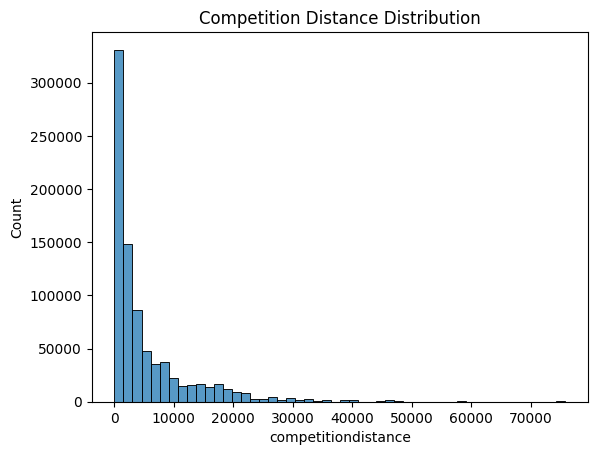

In [53]:
logger.info("Competition Distance Distribution plot started...")
sns.histplot(train_merged["competitiondistance"], bins=50)
plt.title("Competition Distance Distribution")
plt.show()
logger.info("Competition Distance Distribution plotted successfully!")

#### 6.5.4 Distribution Visualization of Numerical Features

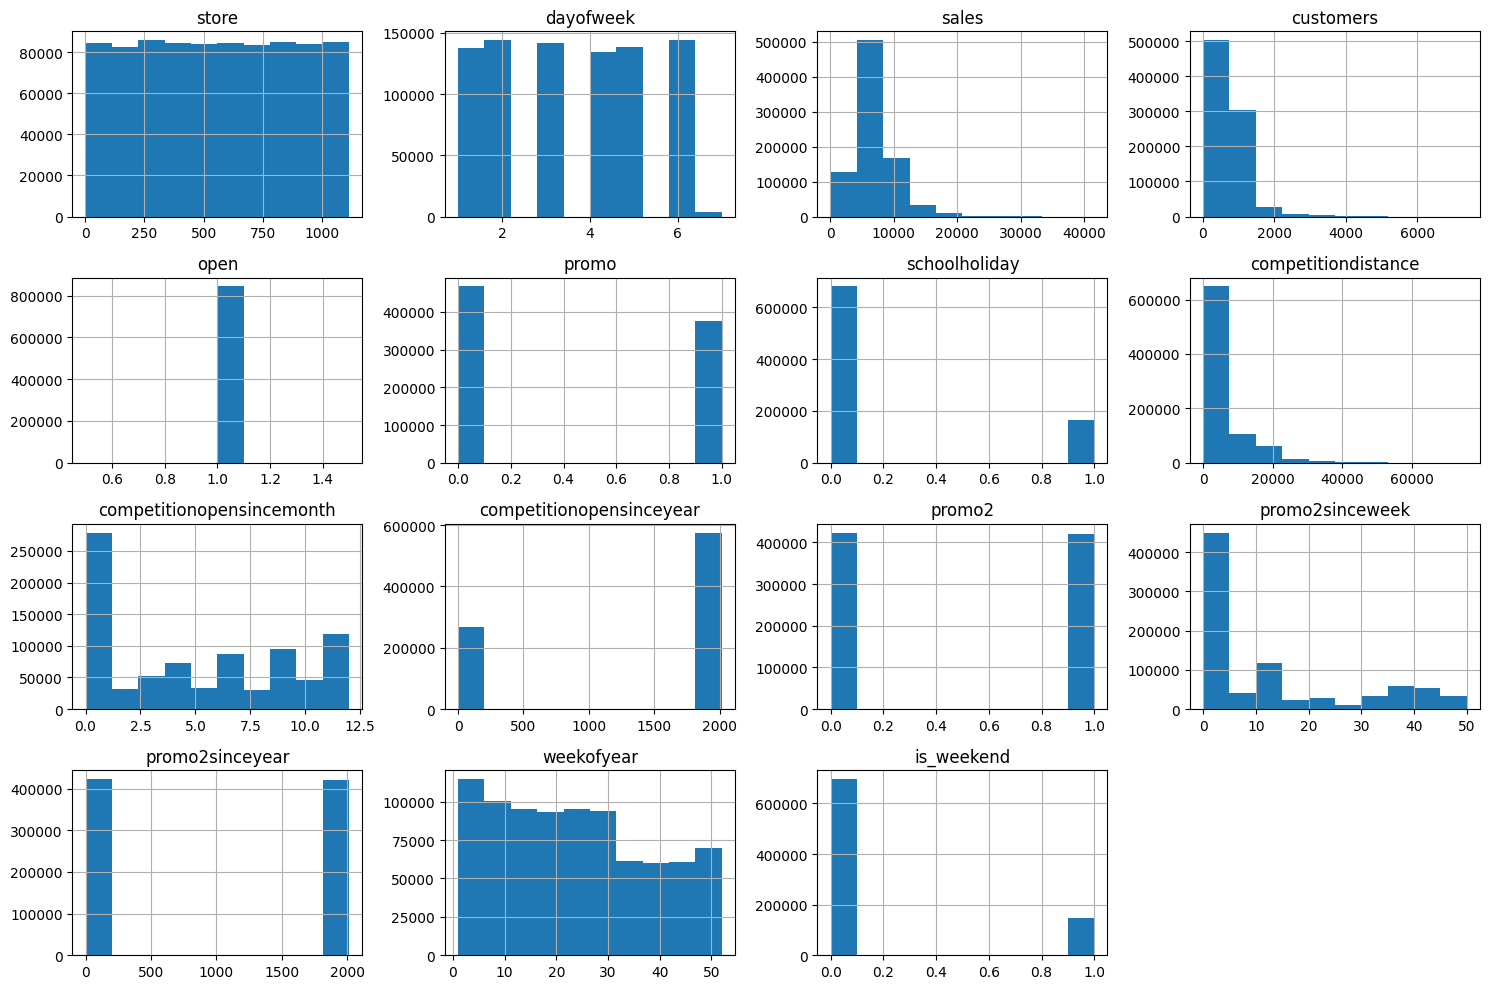

In [54]:
train_merged[numerical_cols].hist(figsize=(15,10))
plt.tight_layout()
plt.show()

#### **6.6 BIVARIATE ANALAYSIS**

Correlation driven bivariate analysis will be performed here resulting in plots to display as a graphical data. This will help in getting better insights to take better decisions.

Goal:
- Auto-detect strongly correlated numeric pairs
- Avoid IDs / categorical noise
- Plot the top decision-useful pairs in the notebook

#### 6.6.1 Promotion Effect on Sales

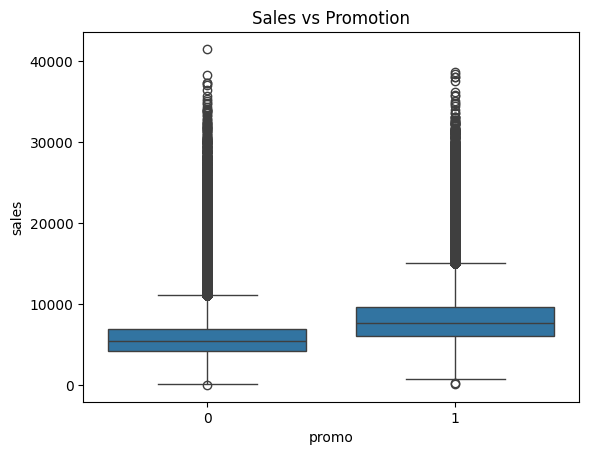

In [55]:
logger.info("Plotting sales vs promotion...")
sns.boxplot(x="promo", y="sales", data=train_merged)
plt.title("Sales vs Promotion")
plt.show()
logger.info(f"Sales vs promotion plotted successfully!")

#### 6.6.2 Store Type Impact

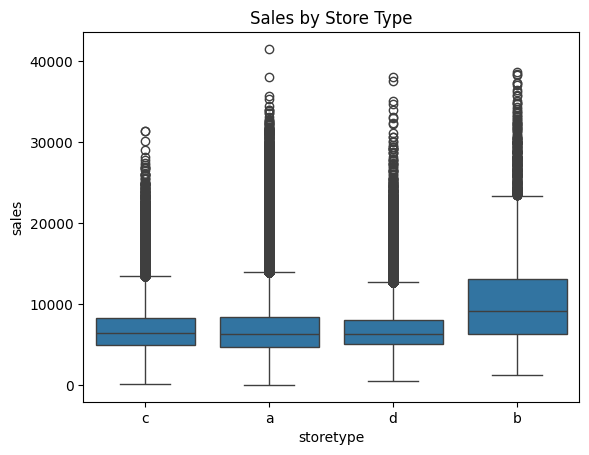

In [56]:
logger.info("Plotting sales by store type...")
sns.boxplot(x="storetype", y="sales", data=train_merged)
plt.title("Sales by Store Type")
plt.show()
logger.info("Sales by store type plotted successfully!")

#### 6.6.3 Weekly Sales Pattern

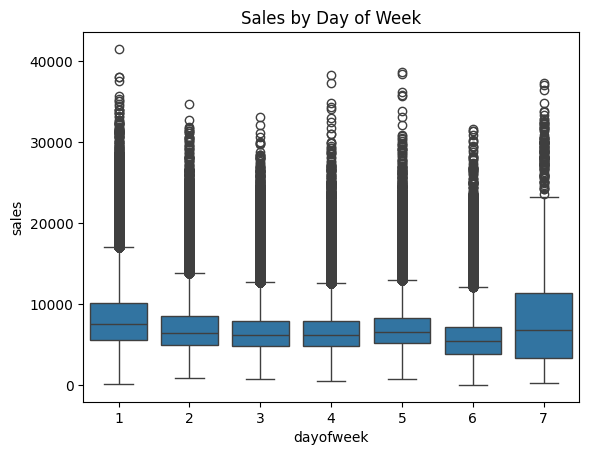

In [57]:
logger.info("Plotting sales by day of week...")
sns.boxplot(x="dayofweek", y="sales", data=train_merged)
plt.title("Sales by Day of Week")
plt.show()
logger.info("Sales by day of week plotted successfully!")

#### 6.6.4 Holiday vs Sales

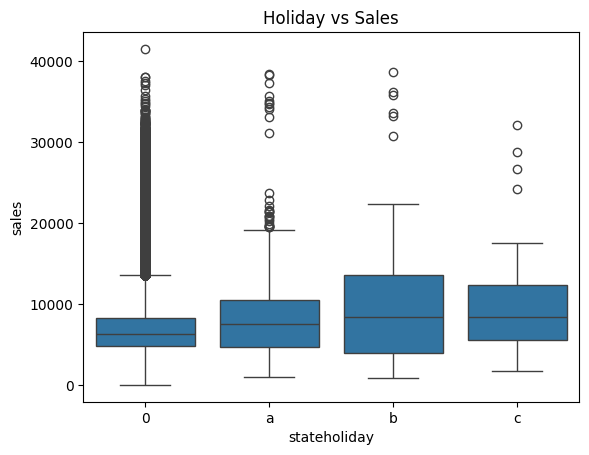

In [58]:
logger.info("Plotting holiday by day sales...")
sns.boxplot(x="stateholiday", y="sales", data=train_merged)
plt.title("Holiday vs Sales")
plt.show()
logger.info("Holiday vs Sales plotted successfully!")

#### 6.6.5 Sales vs. Customers

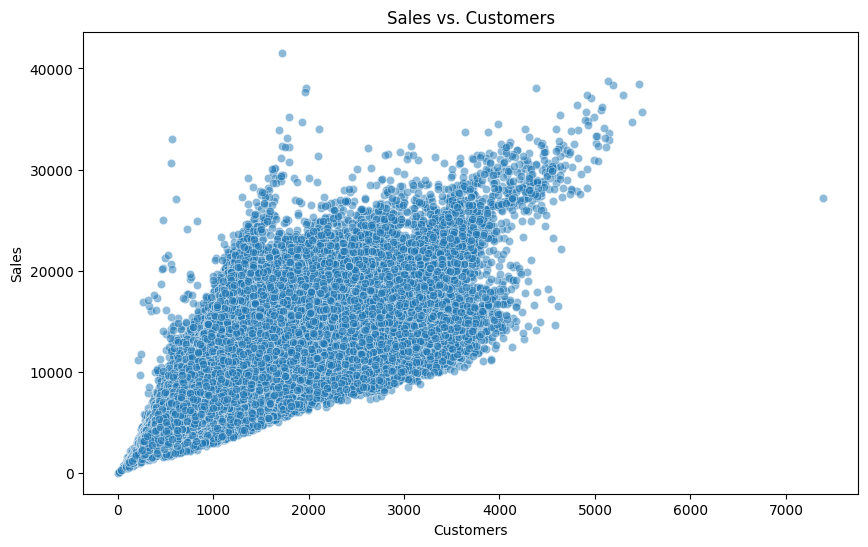

In [59]:
# Plot Sales vs. Customers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='customers', y='sales', data=train_merged, alpha=0.5)
plt.title('Sales vs. Customers')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

#### 6.6.6 Sales trend over time

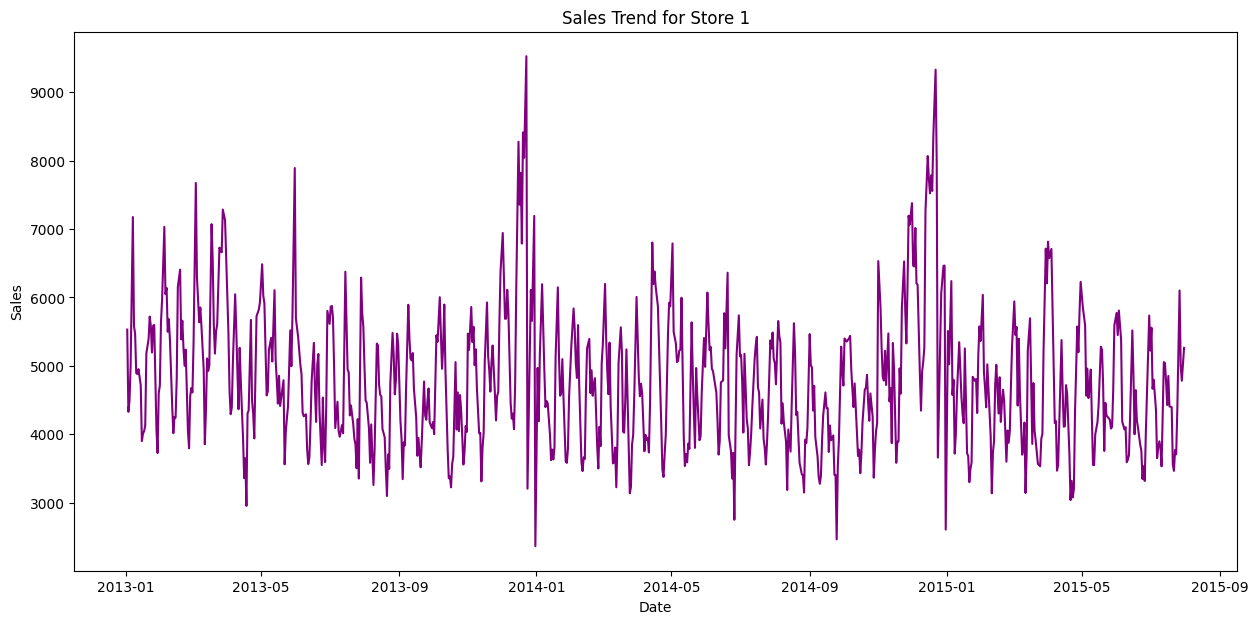

In [60]:
# Plot Sales trend over time for an example store (Store 1)
store1_df = train_merged[train_merged['store'] == 1].sort_values('date')
plt.figure(figsize=(15, 7))
plt.plot(store1_df['date'], store1_df['sales'], color='purple')
plt.title('Sales Trend for Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

#### **6.7 MULTIVARIATE ANALYSIS**
Here we will see relationships between multiple features

#### 6.7.1 Correlation heatmap 
It is the correlation matrix which shows the heatmap and relationship between the features

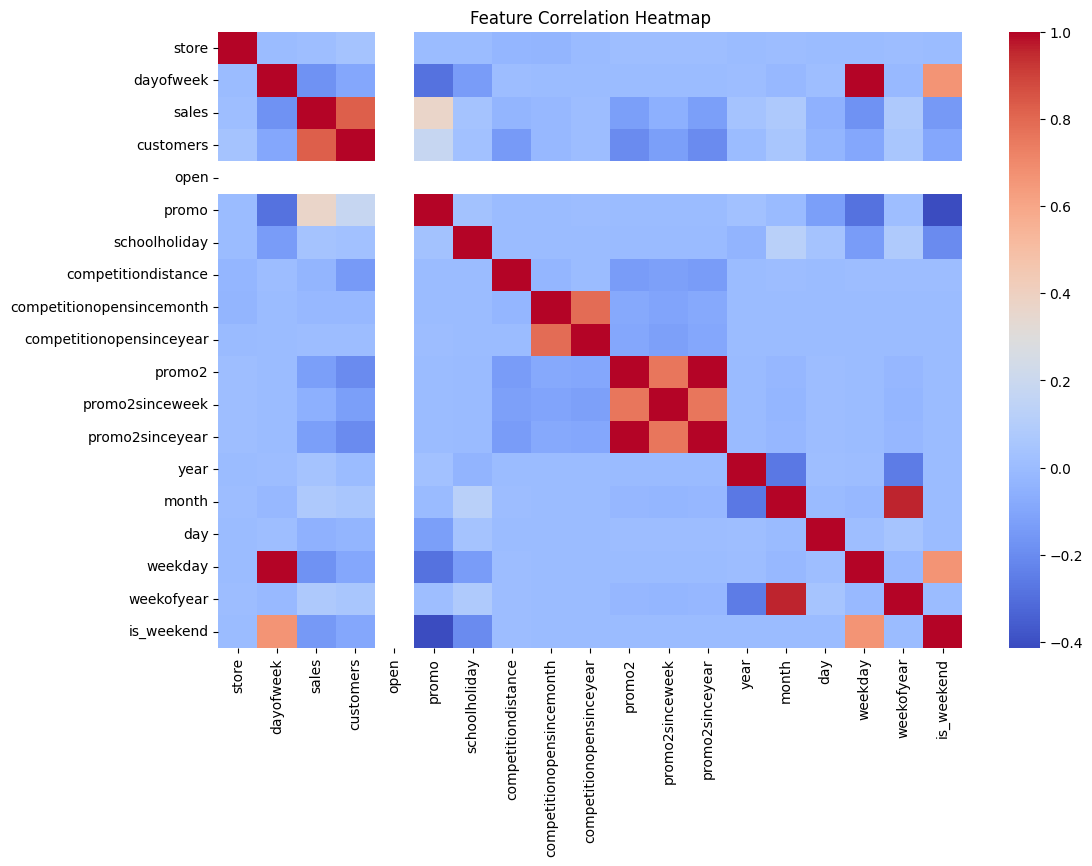

In [61]:
logger.info("Correlationship matrix plotting started...")
plt.figure(figsize=(12,8))
corr = train_merged.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
logger.info("Correlation heatmap plotted successfully!")

#### 6.7.2 Promo + Storetype combined effect

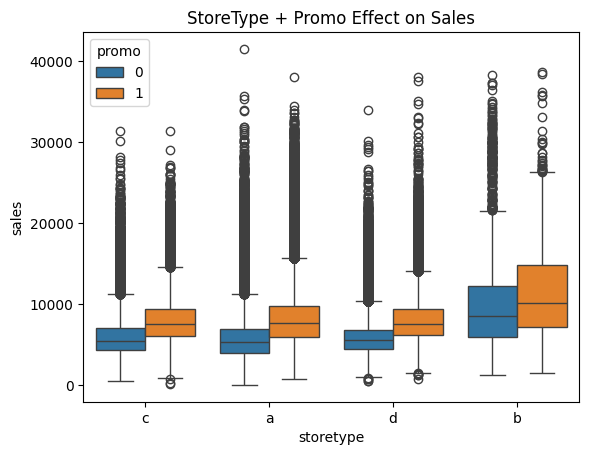

In [62]:
logger.info("Plotting StoreType + Promo Effect on Sales started...")
sns.boxplot(x="storetype", y="sales", hue="promo", data=train_merged)
plt.title("StoreType + Promo Effect on Sales")
plt.show()
logger.info("StoreType + Promo Effect on Sales plotted successfully!")

#### 6.7.3 Pairwise Relationship Analysis (Pairplot)
This code creates a pairplot (scatterplot matrix) using Seaborn to visualize relationships between all numerical variables in the dataset.
It helps perform multivariate exploratory data analysis (EDA). Since data is too large to evaluate, we are using sample to show the pairwise relationships.

Here we are using `diag_kind = 'kde` to display in the plot. But in case it takes a lot of time to display, then we can use `diag_kind='hist'`. `kde` takes some time to load the data, but since we have reduced the size of data to 5000 it will load easily.

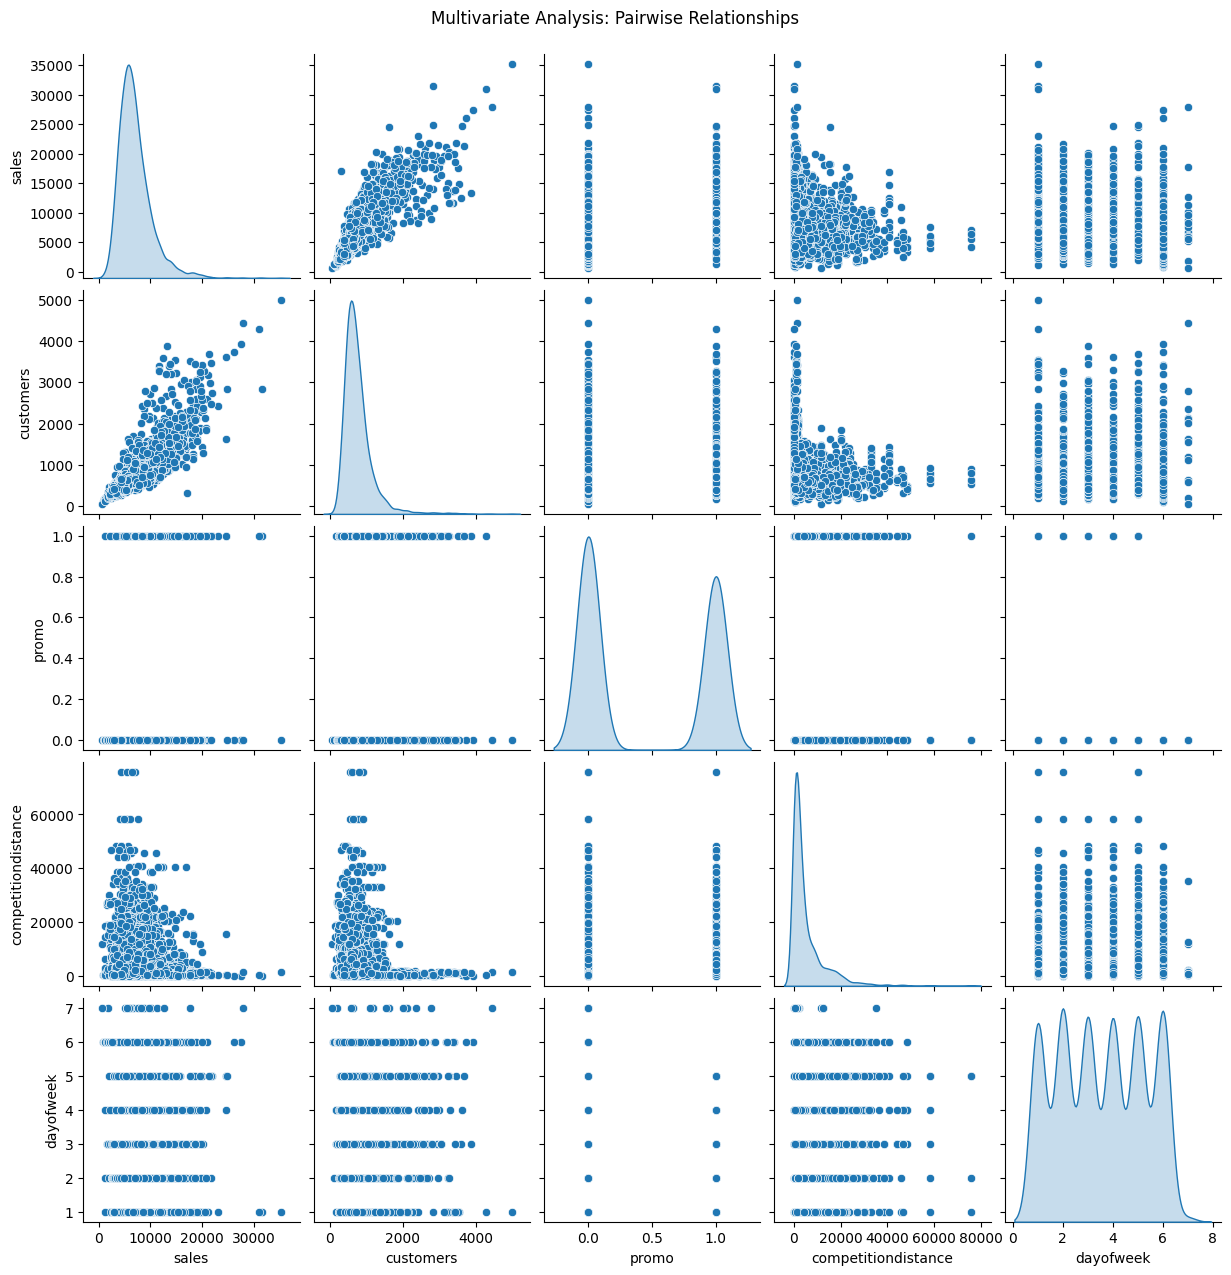

In [63]:
cols = ['sales','customers','promo','competitiondistance','dayofweek']

sample_df = train_merged[cols].sample(5000, random_state=42)

sns.pairplot(sample_df, diag_kind='kde')
plt.suptitle("Multivariate Analysis: Pairwise Relationships", y=1.02)
plt.show()

_____________________________________________

#### **STEP 7 - TREATING OUTLIERS**

In [64]:
# Outlier treatment using capping (auto-detect numeric columns)

# Automatically detect numeric columns (excluding 'store', 'dayofweek', etc. if needed)
num_cols = [col for col in train_merged.select_dtypes(include=["int64", "float64"]).columns if col not in ["store", "dayofweek"]]

for col in num_cols:
    Q1 = train_merged[col].quantile(0.25)
    Q3 = train_merged[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    train_merged[col] = train_merged[col].clip(lower=lower, upper=upper)
    print_and_log(f"\nSummary statistics for {col} after capping:")
    print_and_log(train_merged[col].describe())
    print_and_log(f"Sample rows for {col} after capping:")
    print_and_log(train_merged[col].head())

print_and_log("Outlier treatment completed!")


Summary statistics for sales after capping:
count    844338.000000
mean       6841.079200
std        2716.855718
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       13611.500000
Name: sales, dtype: float64
Sample rows for sales after capping:
0     5263.0
1     6064.0
2     8314.0
3    13611.5
4     4822.0
Name: sales, dtype: float64

Summary statistics for customers after capping:
count    844338.000000
mean        734.834956
std         296.122375
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        1454.000000
Name: customers, dtype: float64
Sample rows for customers after capping:
0     555
1     625
2     821
3    1454
4     559
Name: customers, dtype: int64

Summary statistics for open after capping:
count    844338.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: open, dtype: float64
Sample rows 

_____________________________________________

### **STEP 8 - Export Human-Readable Excel Files**
The merged dataset is very large and cannot be opened entirely in Excel.

Therefore:
- Full datasets are saved as CSV (for machine learning)
- A sample of the dataset is saved as Excel for inspection and evaluation

This allows visualization of merged columns and cleaned data.

In [65]:
logger.info("Saving final CSV datasets...")

train_merged.to_csv("final_train.csv", index=False)
test_merged.to_csv("final_test.csv", index=False)

logger.info("CSV files saved successfully!")

# -------- CREATE EXCEL SAMPLE --------
logger.info("Creating Excel sample files...")

# take manageable sample
sample_train = train_merged.sample(n=20000, random_state=42)
sample_test = test_merged.sample(n=20000, random_state=42)

sample_train.to_excel("sample_train.xlsx", index=False)
sample_test.to_excel("sample_test.xlsx", index=False)

logger.info("Excel sample files created successfully!")

PermissionError: [Errno 13] Permission denied: 'final_train.csv'

`Excel` is not a data-science tool — it is only a data viewing tool.
Models must always train on CSV/parquet, not Excel, hence we did it like that.

**We will get the following:**
- final_train.csv
- final_test.csv
- sample_train.xlsx
- sample_test.xlsx
- logs/merge_eda.log

**What should be checked in excel `IMPORTANT!`**

After opening sample_train.xlsx, verify:
We should now see new columns that did not exist before:
- StoreType
- Assortment
- CompetitionDistance
- Promo2
- PromoInterval

This proves the merge worked correctly.

In [ ]:
print_and_log("===== MERGE & EDA PIPELINE COMPLETED =====")